<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B32_1%5D_Variational_Autoencoder_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Variational  AutoEncoder


<img src="https://miro.medium.com/max/3374/1*22cSCfmktNIwH5m__u2ffA.png" height=200 />

## Import Modul

In [0]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import argparse

## Random Sampling Function

In [0]:
def sampling(args):
  #input:  mean and log of variance 
  z_mean, z_log_var = args
    
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]

  # by default, random_normal has mean=0 and std=1.0
  epsilon = K.random_normal(shape=(batch, dim))
  
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Load MNIST Dataset

In [31]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()


(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

170500096/170498071 [==============================] - 2s 0us/step


## Define VAE Networks

### Network Parameters

In [0]:
input_shape = (image_size, image_size, 1)
batch_size = 128
latent_dim = 2
epochs = 30

### VAE Encoder

In [33]:
inputs = Input(shape=input_shape, name='encoder_input')

x = inputs
x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)


# generate latent vector Q(z|X)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

### VAE Decoder

In [34]:
# build decoder model

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)

outputs = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid',
                          padding='same', name='decoder_output')(x)



# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________


### VAE Model = Encoder + Decoder

In [35]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='dc_vae')
vae.summary()

Model: "dc_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


## Train VAE

### Define Model

In [0]:
models = (encoder, decoder)
data = (x_test, y_test)

### Define Loss

VAE loss = mse_loss + kl_loss

In [0]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size


kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

### Compile Model
Add loss to model and compile it

In [38]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

# plot_model(vae, to_file='dc_vae.png', show_shapes=True)


W0813 02:00:45.694002 140661672724352 training_utils.py:1101] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


Model: "dc_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 69076       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    65089       encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape_6 (TensorFl [(None,)]            0           decoder[1][0]                    
_____________________________________________________________________________________________

### Train DC-VAE

In [39]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 86us/sample - loss: 7.1026 - val_loss: 0.0033
Epoch 2/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0023 - val_loss: 0.0019
Epoch 3/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 4/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 5/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 6/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 7/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 8/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 9/30
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0014 - val_

## Visualize Generated Images

Plots labels and MNIST digits as function of 2-dim latent vector

### Visualize Latent Space

In [0]:
def plot_latent_space(models, data, batch_size=128):

    encoder, decoder = models
    x_test, y_test = data
    
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


In [0]:
plot_latent_space(models, data, batch_size=batch_size)

### Visualize Randomly Generated

In [0]:
def plot_interpolating(models, data, batch_size=128):

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    
    encoder, decoder = models
    x_test, y_test = data

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


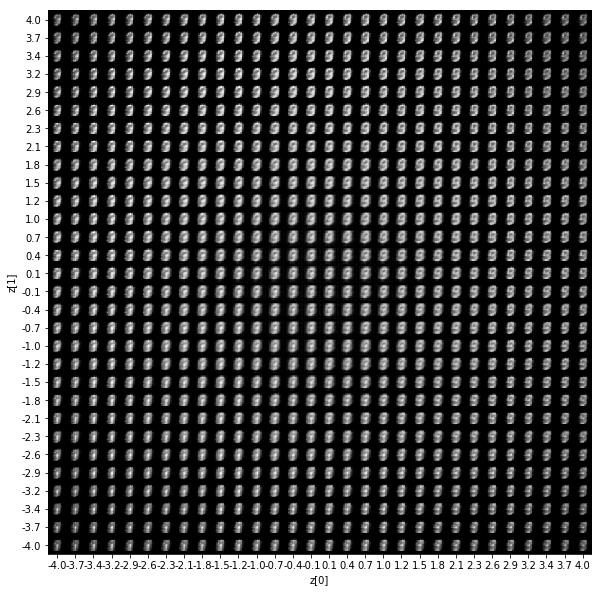

In [44]:
plot_interpolating(models, data, batch_size=batch_size)

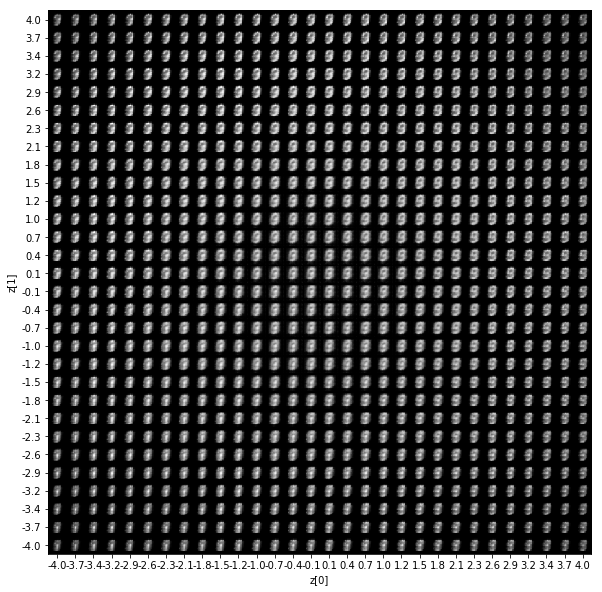

In [45]:
plot_interpolating(models, data, batch_size=batch_size)

Run again `plot_interpolating` to view different interpolation

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>